# Starter notebook for Oxford IIIT Pets using Torchvision and Albumenations

This is a starter notebook that shows how to use the Oxford IIIT Pet dataset with Torchvision in Kaggle notebooks w/o downloading it. We create a symlink in the working directory in the format that torchvision expects to make this work.


In [1]:
import torch
import torchvision
import os
from matplotlib import pyplot
from PIL import Image
import numpy as np

# Convert a PIL image to a PyTorch float tensor
img2t = torchvision.transforms.ToTensor()
# Convery a PyTorch float tensor to a PIL image
t2img = torchvision.transforms.ToPILImage()

## Torchvision dataset

Create symlinks and point `torchvision.datasets.OxfordIIITPet` to this location.

In [2]:
# Oxford IIIT Pets Segmentation dataset loaded via torchvision.
# !rm -f '/kaggle/working/oxford-iiit-pet'
# !ln -s '/kaggle/input/oxfordiiitpetfromxijiatao/Oxford-IIT-Pet' '/kaggle/working/oxford-iiit-pet'

# oxford_pets_path = '/kaggle/working'
pets_train_orig = torchvision.datasets.OxfordIIITPet(root="../data", split="trainval", target_types="segmentation", download=False)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root="../data", split="test", target_types="segmentation", download=False)

In [3]:
pets_train_orig, pets_test_orig

(Dataset OxfordIIITPet
     Number of datapoints: 3680
     Root location: ../data,
 Dataset OxfordIIITPet
     Number of datapoints: 3669
     Root location: ../data)

## Display images and segmentation masks

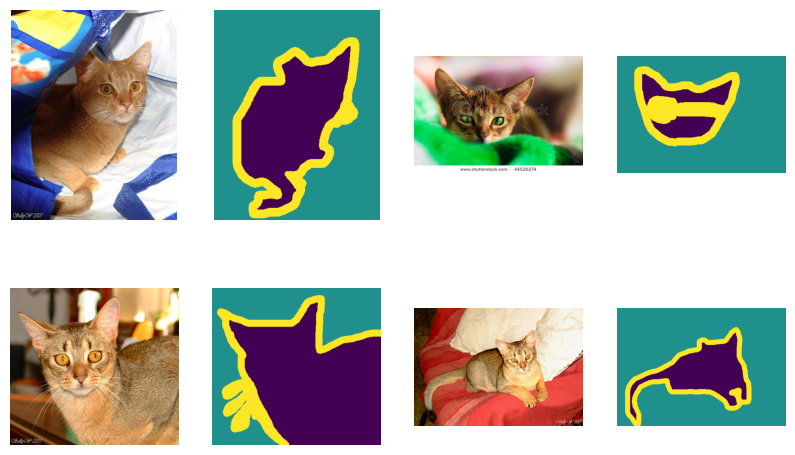

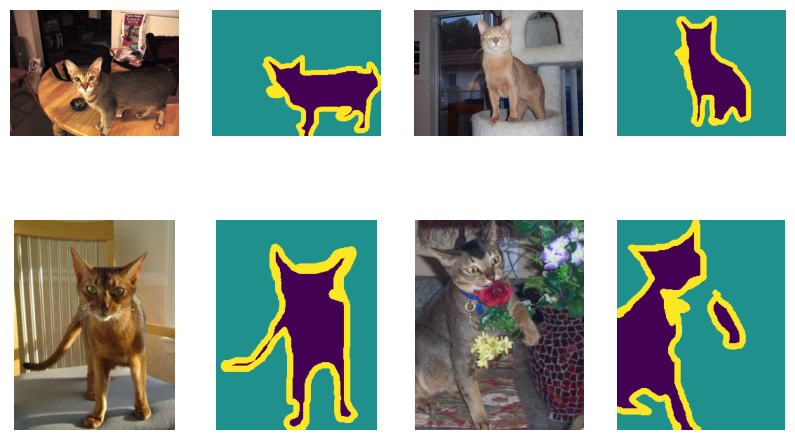

In [4]:
def display_images_and_masks(dataset, indexes):
  """Display images and segmentation masks next to each other.
  """
  # Display a maximum of 2 sets of (image, mask) pairs per row.
  nrows = (len(indexes) + 1) // 2
  # 3 units height per row.
  fig = pyplot.figure(figsize=(10, 3 * nrows))
  for i in range(len(indexes)):
    image, mask = dataset[i][0], dataset[i][1]
    fig.add_subplot(nrows, 4, i*2+1)
    pyplot.imshow(image)
    pyplot.axis("off")
    
    fig.add_subplot(nrows, 4, i*2+2)
    pyplot.imshow(mask)
    pyplot.axis("off")
  # end for
# end def

# Display 4 training and test images.
display_images_and_masks(pets_train_orig, indexes=(0, 1, 2, 3))
pyplot.show()

display_images_and_masks(pets_test_orig, indexes=(0, 1, 2, 3))
pyplot.show()

## Resize images to 128x128

Resize the images to 128x128 using torchvision transforms, and display the results.

(394, 500) (128, 128)


(-0.5, 127.5, 127.5, -0.5)

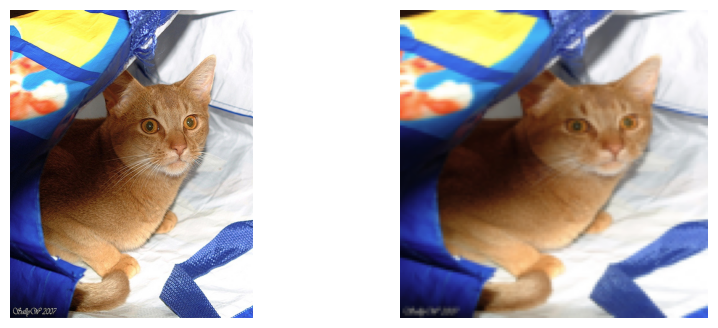

In [5]:
resizer = torchvision.transforms.Resize((128, 128))
image = pets_train_orig[0][0]
image128 = resizer(image)

print(image.size, image128.size)

fig = pyplot.figure(figsize=(10, 4))
pyplot.subplot(1, 2, 1)
pyplot.imshow(image)
pyplot.axis("off")

pyplot.subplot(1, 2, 2)
pyplot.imshow(image128)
pyplot.axis("off")

## Apply multiple color transforms using torchvision

And display the results.

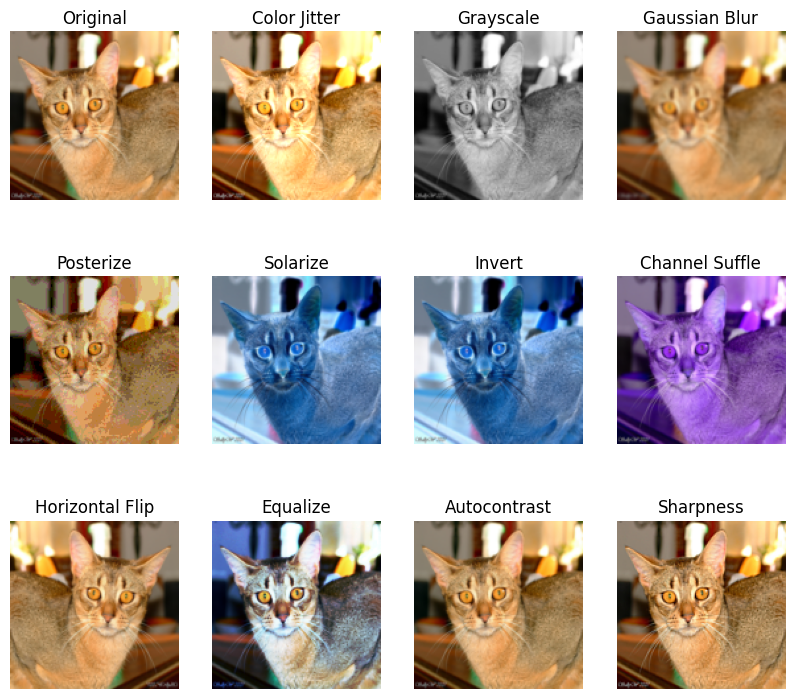

In [6]:
def display_images_with_augmentations(image, transforms, labels):
  # Display a maximum of 4 images per row.
  nrows = (len(transforms) + 1 + 3) // 4
  # 3 units height per row.
  fig = pyplot.figure(figsize=(10, 3 * nrows))
  
  # The first time an image is displayed, don't transform it.
  transforms = [lambda x: x] + transforms
  labels = ["Original"] + labels

  for i in range(len(transforms)):
    timage = transforms[i](image)
    args = {}
    if timage.mode == 'L':
        args['cmap'] = 'gray'
    fig.add_subplot(nrows, 4, i+1)
    pyplot.title(labels[i])
    pyplot.imshow(timage, **args)
    pyplot.axis("off")
  # end for
# end def

class ChannelShuffle():
  def __init__(self, permute):
    super().__init__()
    self.permute = list(permute)
      
  def __call__(self, x):
    if isinstance(x, Image.Image):
      t = img2t(x)
      back = t2img
    else:
      t = x
      back = lambda x: x
    
    tnew = t[self.permute]
    return back(tnew)
    
image = torchvision.transforms.Resize((128, 128))(pets_train_orig[2][0])
transforms = [
  torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5),
  torchvision.transforms.Grayscale(num_output_channels=1),
  torchvision.transforms.GaussianBlur(kernel_size=5),
  torchvision.transforms.RandomPosterize(bits=3, p=1.0),
  torchvision.transforms.RandomSolarize(threshold=0.3, p=1.0),
  torchvision.transforms.RandomInvert(p=1.0),
  ChannelShuffle((1, 2, 0)),
  torchvision.transforms.RandomHorizontalFlip(p=1.0),
  torchvision.transforms.RandomEqualize(p=1.0),
  torchvision.transforms.RandomAutocontrast(p=1.0),
  torchvision.transforms.RandomAdjustSharpness(sharpness_factor=2.0, p=1.0),
]
labels = [
  "Color Jitter", "Grayscale", "Gaussian Blur", "Posterize",
  "Solarize", "Invert", "Channel Suffle", "Horizontal Flip",
  "Equalize", "Autocontrast", "Sharpness",
]
display_images_with_augmentations(image, transforms, labels)

## Display images with segmentation masks overlaid using torchvision

Torchvision provides utilities to visualize images with overlaid segmentation masks. This section shows how to use these utilities.

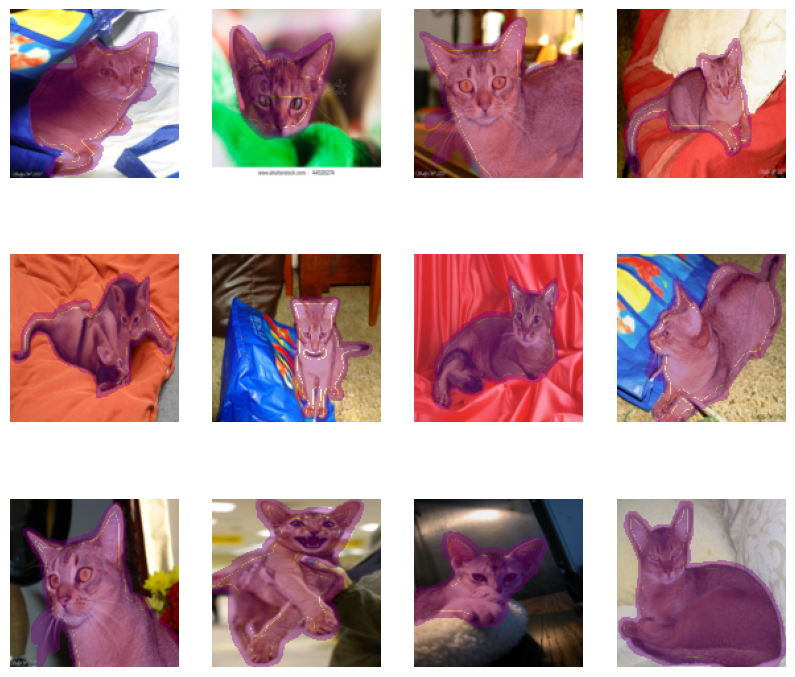

In [7]:
def image_with_segmask(image, mask):
  # image and mask are PIL images. First convert them to a uint8 np.array
  # and then into a pytorch tensor. The dimensions are ordered as HWC, so
  # we permute them to be CHW since draw_segmentation_masks() accepts CHW
  # image tensors.
  imaget = torch.tensor(np.array(image)).permute(2, 0, 1)
  maskt = torch.tensor(np.array(mask)).unsqueeze(0)
  
  # Convert maskt into a boolean tensor since that is what
  # draw_segmentation_masks() accepts. 2 is the background pixel, so we
  # remove it and keep the rest as the segmentation mask.
  maskt = (maskt != 2)
  
  # Return a tensor with the segmentation mask superimposed in green colour
  # with 0.4 opacity.
  return torchvision.utils.draw_segmentation_masks(image=imaget, masks=maskt, alpha=0.4, colors="purple")

def grid_image_with_segmask(dataset, indexes):
  # We resize the image and segmentation mask to 128x128
  # before plotting them.
  resizer = torchvision.transforms.Resize((128, 128))
  # Plot 4 images per row tops.
  nrows = (len(indexes) + 3) // 4
  fig = pyplot.figure(figsize=(10, nrows*3))
  for i in indexes:
    image, mask = dataset[i][0].convert("RGB"), dataset[i][1]
    image128, mask128 = resizer(image), resizer(mask)
    
    imaget = image_with_segmask(image128, mask128)
    pyplot.subplot(nrows, 4, i+1)
    pyplot.imshow(t2img(imaget))
    pyplot.axis("off")
  # end for
# end def

# Plot 12 images with their segmentation masks.
grid_image_with_segmask(pets_train_orig, indexes=list(range(12)))

# Albumenations

In this section, we'll see how to use Albumenations for data augmentation on images. Albumenations is able to perform simultaneous augmentations on both the images as well as the segmentation masks, making it much easier to perform more complex spatial transforms on the image and segmentation masks simultaneously. This capability extends to bounding boxes as well as keypoints.

See the full reference for more details: https://albumentations.ai/docs/api_reference/full_reference/

In [8]:
import albumentations as A
import cv2

In [9]:
def show_pair(image, mask):
  """Display a pair of image beside each other. Typically
  this is the image along with its segmentation mask.
  """
  fig = pyplot.figure(figsize=(7, 3))
  pyplot.subplot(1, 2, 1)
  pyplot.imshow(image)
  pyplot.axis("off")

  pyplot.subplot(1, 2, 2)
  pyplot.imshow(mask)
  pyplot.axis("off")


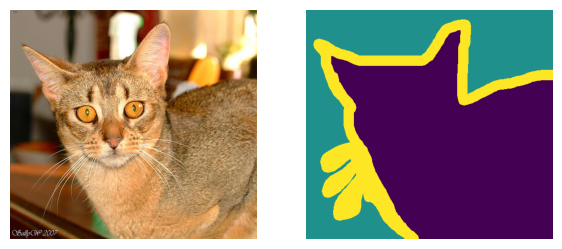

In [10]:
image, mask = pets_train_orig[2][0], pets_train_orig[2][1]
pil_image = image.convert("RGB")
# OpenCV uses BGR images, but Albumenations expects RGB images, so if we start
# with a PIL image, then we just convert it into a NumPy array, which is RGB
# ordered
opencv_image = np.array(pil_image)
opencv_mask = np.array(mask)
show_pair(opencv_image, opencv_mask)
pyplot.show()

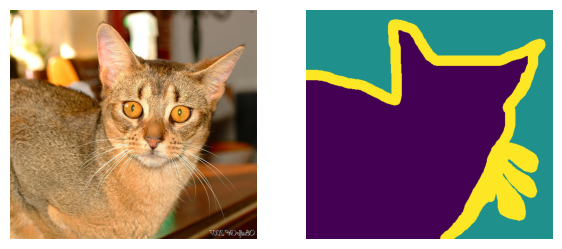

In [11]:
flipper = A.HorizontalFlip(p=1.0)
flipped = flipper(image=opencv_image, mask=opencv_mask)

# Plot the image and the mask alongside each other.
show_pair(flipped['image'], flipped['mask'])
pyplot.show()

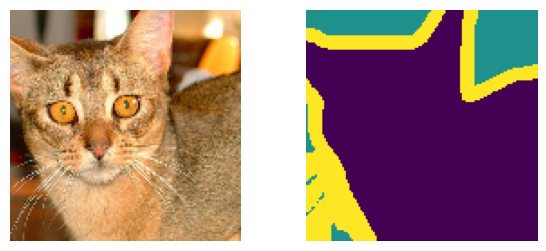

In [ ]:
tx = A.Compose([
  A.CenterCrop(350, 350),
  A.Resize(128, 128),
])
txed = tx(image=opencv_image, mask=opencv_mask)
show_pair(txed['image'], txed['mask'])
pyplot.show()

## Apply multiple spatial transforms using Albumenations

And display the results.

/var/folders/hq/4mqp376n3t98jm_dyrb8pkbw0000gn/T/ipykernel_52922/2219408079.py:32: UserWarning: Argument(s) 'max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(p=1.0, max_height=32, max_width=32),
/Users/jason/.pyenv/versions/3.10.14/lib/python3.10/site-packages/albumentations/core/validation.py:58: UserWarning: This augmenter is very slow. Try to use ``ElasticTransform`` instead, which is at least 10x faster.
  original_init(self, **validated_kwargs)


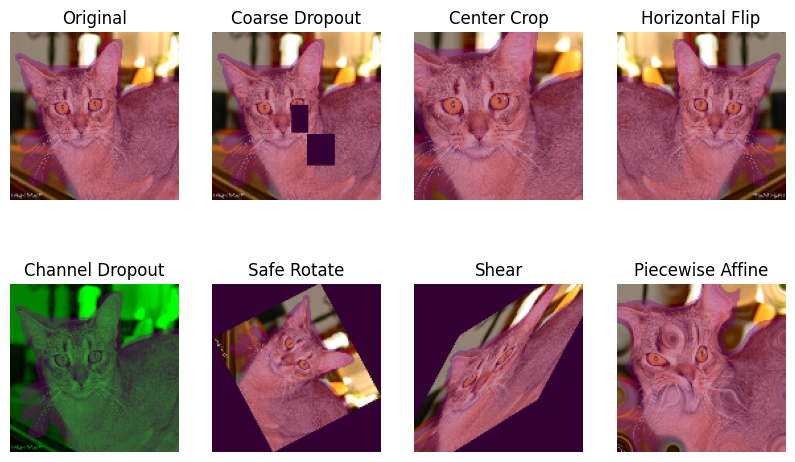

In [ ]:
def display_all_transformed(image, mask, transforms, labels, resizer):
  # Display a maximum of 4 images per row.
  nrows = (len(transforms) + 1 + 3) // 4
  # 3 units height per row.
  fig = pyplot.figure(figsize=(10, 3 * nrows))

  # The first time an image is displayed, don't transform it.
  transforms = [lambda **kwargs: kwargs] + transforms
  labels = ["Original"] + labels

  for i in range(len(transforms)):
    txed = transforms[i](image=image, mask=mask)
    # Covert to PIL Image.
    pil_image = Image.fromarray(txed['image'])
    pil_mask = Image.fromarray(txed['mask'])

    args = {}
    if pil_image.mode == 'L':
      args['cmap'] = 'gray'
    fig.add_subplot(nrows, 4, i+1)
    pyplot.title(labels[i])
    
    # Convert from CHW to HWC by permuting dimensions.
    image_with_mask = image_with_segmask(pil_image, pil_mask).permute(1, 2, 0).numpy()
    image_with_mask = resizer(image=image_with_mask)['image']
    pyplot.imshow(Image.fromarray(image_with_mask), **args)
    pyplot.axis("off")
  # end for
# end def

transforms = [
  A.CoarseDropout(p=1.0, max_height=32, max_width=32),
  A.CenterCrop(350, 350),
  A.HorizontalFlip(p=1.0),
  A.ChannelDropout(channel_drop_range=(1, 2), p=1.0),
  A.SafeRotate(p=1.0),
  A.Affine(shear=30.0, p=1.0),
  A.PiecewiseAffine(p=1.0),
]
final_resize = A.Resize(128, 128)

labels = "Coarse Dropout,Center Crop,Horizontal Flip,Channel Dropout,Safe Rotate,Shear,Piecewise Affine".split(",")

display_all_transformed(opencv_image, opencv_mask, transforms, labels, final_resize)